#Import Library

In [1]:
pip install ccxt cryptocompare pycoingecko websockets ta nest_asyncio tensorflow scikeras catboost optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.2/132.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.0/644.0 kB 30.4 MB/s eta 0:00:00
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6291 sha256=5c8dd35e3ff702fc5a7b5e8b4917f9906211a2435d6760fdd2cf17223a640710
  Stored in directory: /root/.cache/pip/wheels/ac/d9/d3/45937831310f976e534a0a1dd2566a04e9d17ecd42a6932f31
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=23b7cdb41be62cd5c572ce8897331aeed4047d21144890ce83eeb35f3b5a5db7
  Stored in directory: /ro

In [2]:
pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 51.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


In [37]:
#Import libraries
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
from scipy.stats import pearsonr, jarque_bera
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, confusion_matrix, f1_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline as pl
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
import requests
import ccxt
from cryptocompare import get_historical_price_minute
from pycoingecko import CoinGeckoAPI
import json
from datetime import datetime, timedelta
import time
import websockets
import asyncio
import nest_asyncio
import aiohttp
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ta import add_all_ta_features  # Library khusus technical analysis
from typing import Dict, Any
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from datetime import datetime
from collections import deque
from google.colab import files, drive
import joblib
import pickle
import optuna
from optuna.samplers import TPESampler
warnings.filterwarnings("ignore")

%matplotlib inline

# Import Historical Data

In [5]:
def fetch_historical_data(symbol='BTC', currency='USD', days=365):
    # CryptoCompare (OHLCV per menit)
    cc_url = f"https://min-api.cryptocompare.com/data/v2/histominute?fsym={symbol}&tsym={currency}&limit={min(days*1440, 2000)}"
    cc_data = requests.get(cc_url).json()['Data']['Data']
    df_cc = pd.DataFrame(cc_data)
    df_cc['time'] = pd.to_datetime(df_cc['time'], unit='s', utc=True)

    # CoinGecko (Metadata)
    cg = CoinGeckoAPI()
    cg_data = cg.get_coin_market_chart_by_id(
        id='bitcoin',
        vs_currency=currency.lower(),
        days=days
    )
    df_cg = pd.DataFrame({
        'time': pd.to_datetime([x[0] for x in cg_data['prices']], unit='ms', utc=True),
        'market_cap': [x[1] for x in cg_data['market_caps']],
        'total_volume': [x[1] for x in cg_data['total_volumes']]
    })

    # Gabungkan
    return pd.merge_asof(
        df_cc.sort_values('time'),
        df_cg.sort_values('time'),
        on='time',
        direction='nearest'
    ).set_index('time').resample('1S').ffill()

btc_data = fetch_historical_data(days=30)

In [6]:
btc_data.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,market_cap,total_volume
time,,,,,,,,,,
2025-08-11 20:26:00+00:00,118863.61,118831.9,118852.69,10.11,1201926.98,118831.9,direct,,2.365074e+12,6.268540e+10
2025-08-11 20:26:01+00:00,118863.61,118831.9,118852.69,10.11,1201926.98,118831.9,direct,,2.365074e+12,6.268540e+10
2025-08-11 20:26:02+00:00,118863.61,118831.9,118852.69,10.11,1201926.98,118831.9,direct,,2.365074e+12,6.268540e+10
2025-08-11 20:26:03+00:00,118863.61,118831.9,118852.69,10.11,1201926.98,118831.9,direct,,2.365074e+12,6.268540e+10
2025-08-11 20:26:04+00:00,118863.61,118831.9,118852.69,10.11,1201926.98,118831.9,direct,,2.365074e+12,6.268540e+10


In [7]:
btcdata = btc_data.drop(['conversionType', 'conversionSymbol'], axis=1)

In [8]:
btcdata

,high,low,open,volumefrom,volumeto,close,market_cap,total_volume
time,,,,,,,,
2025-08-11 20:26:00+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:01+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:02+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:03+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:04+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
...,...,...,...,...,...,...,...,...
2025-08-13 05:45:56+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10
2025-08-13 05:45:57+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10
2025-08-13 05:45:58+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10


In [9]:
btcdata.rename(columns={'volumeto': 'volume'}, inplace=True)

In [10]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume
time,,,,,,,,
2025-08-11 20:26:00+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:01+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:02+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:03+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
2025-08-11 20:26:04+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10
...,...,...,...,...,...,...,...,...
2025-08-13 05:45:56+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10
2025-08-13 05:45:57+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10
2025-08-13 05:45:58+00:00,119177.13,119101.28,119177.13,7.235,861798.49,119128.35,2.376233e+12,4.860979e+10


#Feature Engineering

In [11]:
btcdata['next_price'] = btcdata['close'].shift(-1800)
btcdata = btcdata.dropna(subset=['next_price'])

In [12]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
time,,,,,,,,,
2025-08-11 20:26:00+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10,118823.92
2025-08-11 20:26:01+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10,118823.92
2025-08-11 20:26:02+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10,118823.92
2025-08-11 20:26:03+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10,118823.92
2025-08-11 20:26:04+00:00,118863.61,118831.90,118852.69,10.110,1201926.98,118831.90,2.365074e+12,6.268540e+10,118823.92
...,...,...,...,...,...,...,...,...,...
2025-08-13 05:15:56+00:00,119403.23,119387.71,119387.71,4.263,508931.27,119403.23,2.375739e+12,4.749596e+10,119128.35
2025-08-13 05:15:57+00:00,119403.23,119387.71,119387.71,4.263,508931.27,119403.23,2.375739e+12,4.749596e+10,119128.35
2025-08-13 05:15:58+00:00,119403.23,119387.71,119387.71,4.263,508931.27,119403.23,2.375739e+12,4.749596e+10,119128.35


In [13]:
btcdata.columns

Index(['high', 'low', 'open', 'volumefrom', 'volume', 'close', 'market_cap',
       'total_volume', 'next_price'],
      dtype='object')

In [14]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-11 20:26:00+00:00 to 2025-08-13 05:16:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


In [15]:
btcdata.isnull().sum()

,0
high,0
low,0
open,0
volumefrom,0
volume,0
close,0
market_cap,0
total_volume,0
next_price,0


In [16]:
btcdata.shape

(118201, 9)

In [17]:
btcdata.describe()

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
count,118201.000000,118201.000000,118201.000000,118201.000000,1.182010e+05,118201.000000,1.182010e+05,1.182010e+05,118201.000000
mean,119251.016561,119197.435779,119224.951102,48.890652,5.851522e+06,119225.357040,2.372509e+12,5.030818e+10,119232.327726
std,501.508318,497.087642,499.984099,574.740806,6.896735e+07,500.027143,9.504537e+09,5.770941e+09,499.767763
min,118250.680000,118106.910000,118201.630000,0.428700,5.091915e+04,118201.630000,2.357431e+12,4.250868e+10,118201.630000
25%,118877.070000,118821.630000,118849.570000,4.849000,5.757479e+05,118849.570000,2.365402e+12,4.690844e+10,118850.940000
50%,119135.510000,119085.800000,119110.870000,8.467000,1.008912e+06,119110.870000,2.370164e+12,4.756885e+10,119132.970000
75%,119669.820000,119613.210000,119637.860000,16.050000,1.917420e+06,119638.980000,2.379845e+12,5.110829e+10,119641.600000
max,120337.170000,120268.210000,120303.170000,18584.180000,2.230748e+09,120322.290000,2.391124e+12,6.361920e+10,120322.290000


In [18]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-11 20:26:00+00:00 to 2025-08-13 05:16:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


#Check Correlation

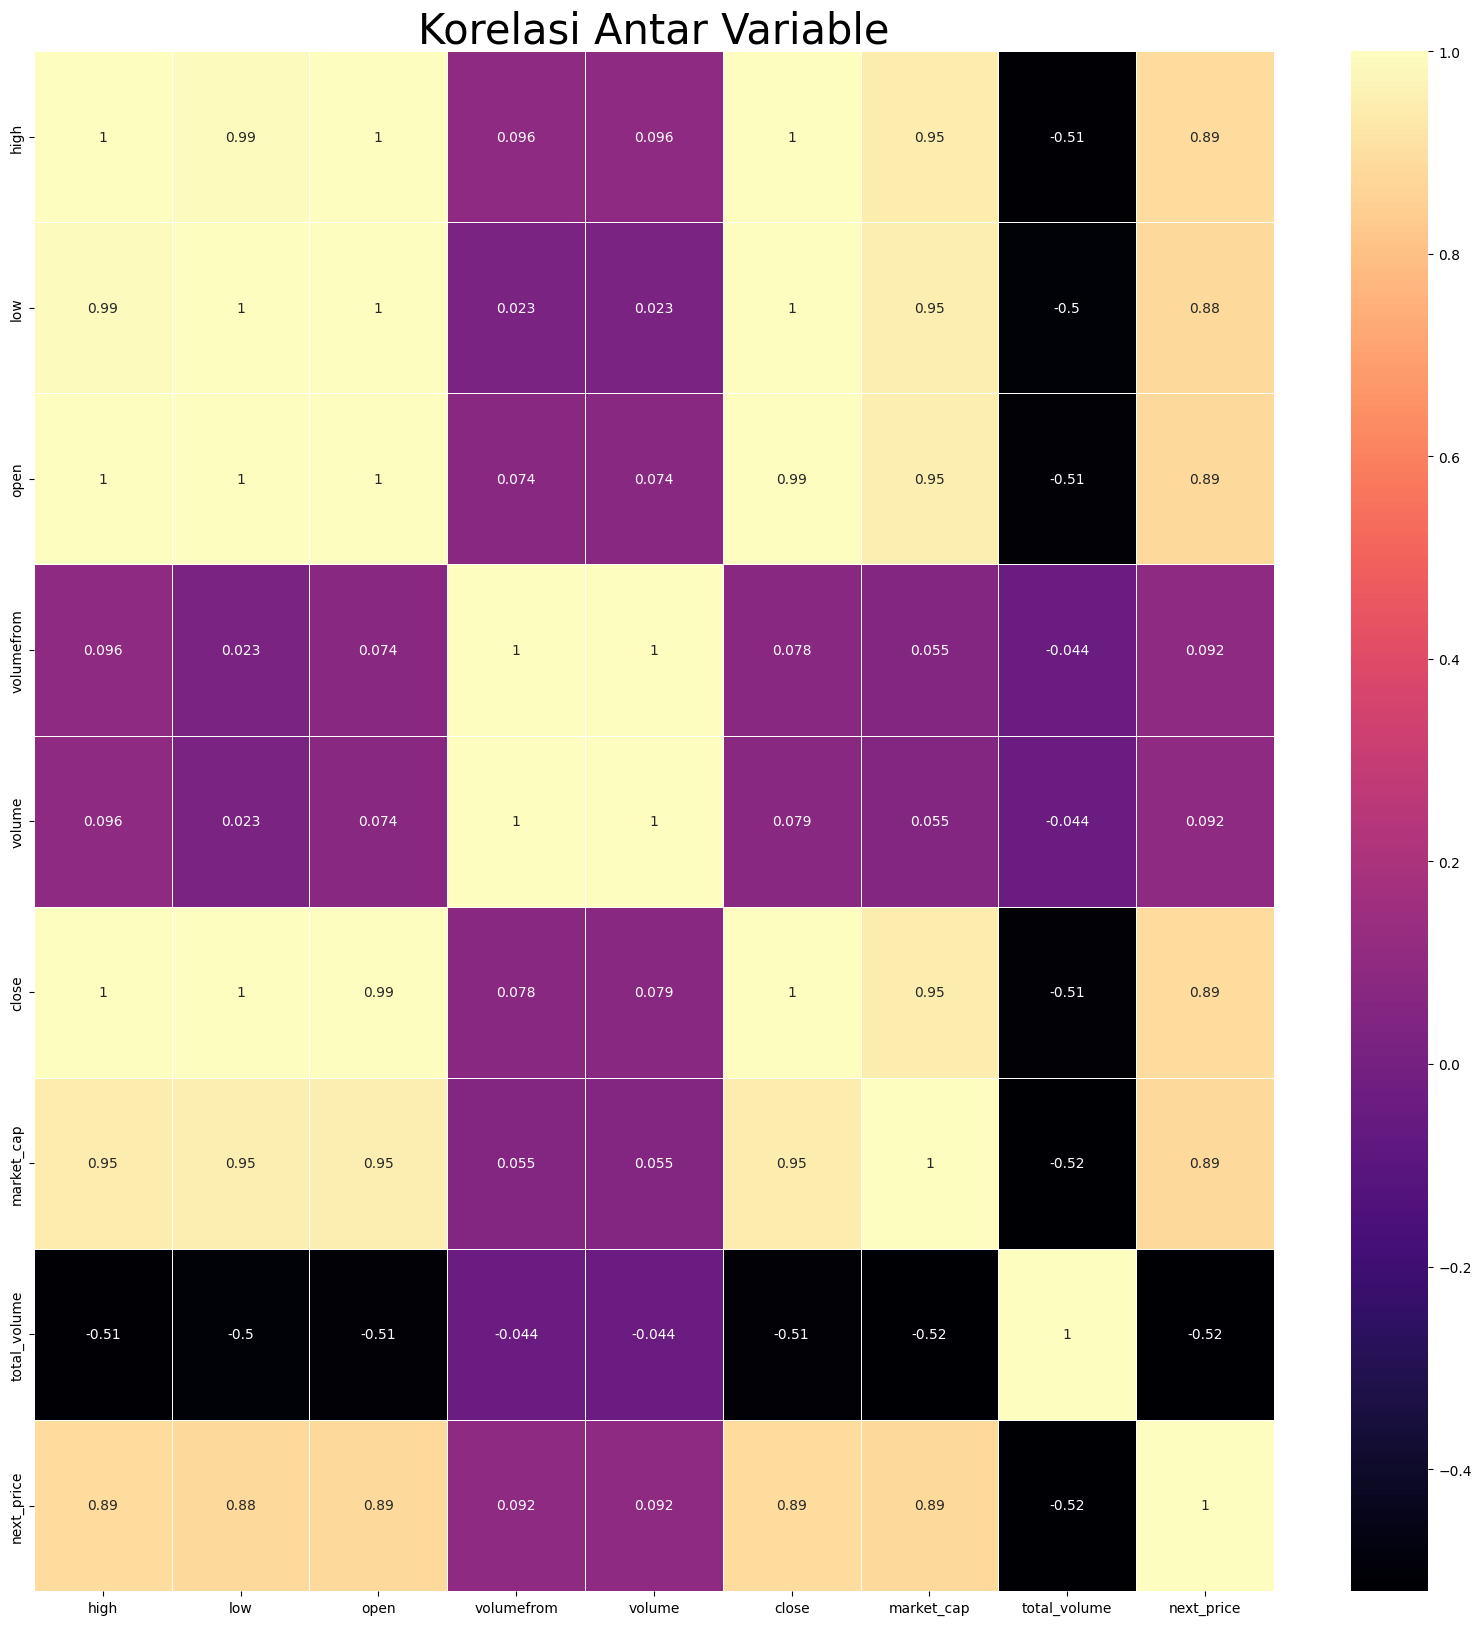

In [19]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

In [20]:
cor_matrix = btcdata.corr()
cor_matrix['next_price'].sort_values()

,next_price
total_volume,-0.515504
volumefrom,0.091646
volume,0.091678
low,0.883587
open,0.886640
market_cap,0.887018
close,0.889328
high,0.889459
next_price,1.000000


In [21]:
select_columns = ['open', 'high', 'low', 'close', 'market_cap', 'next_price']
btcdata = btcdata[select_columns]

In [22]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-11 20:26:00+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:01+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:02+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:03+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:04+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
...,...,...,...,...,...,...
2025-08-13 05:15:56+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35
2025-08-13 05:15:57+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35
2025-08-13 05:15:58+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35


#Check Multicollinearity

In [23]:
def analyze_feature_correlation(df, target_col='next_5m_price', high_corr_threshold=0.9, target_corr_threshold=0.3):
    corr_matrix = df.corr()

    # 1. Korelasi antar fitur
    print("=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= high_corr_threshold and col1 != target_col and col2 != target_col:
                high_corr_pairs.append((col1, col2, corr_value))

    if high_corr_pairs:
        for col1, col2, corr_value in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"{col1} vs {col2}: corr = {corr_value:.3f}")
    else:
        print("Tidak ada korelasi tinggi antar fitur.")

    # 2. Korelasi fitur dengan target
    print("\n=== Korelasi fitur dengan target (next_3m_price) ===")
    target_corr = corr_matrix[target_col].drop(target_col)
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

    for col, val in target_corr_sorted.items():
        tag = "✅" if abs(val) >= target_corr_threshold else "⚠️"
        print(f"{tag} {col}: corr = {val:.3f}")

    # 3. Rekomendasi drop kandidat (multikolinearitas)
    print("\n=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===")
    to_drop = set()
    for col1, col2, _ in high_corr_pairs:
        # Bandingkan mana yang lebih penting dengan target
        corr1 = abs(corr_matrix[col1][target_col])
        corr2 = abs(corr_matrix[col2][target_col])
        drop = col1 if corr1 < corr2 else col2
        to_drop.add(drop)

    if to_drop:
        print("Fitur yang disarankan untuk di-drop:")
        for f in to_drop:
            print(f"❌ {f}")
    else:
        print("Tidak ada fitur yang disarankan untuk di-drop.")

    return {
        "high_corr_pairs": high_corr_pairs,
        "target_correlation": target_corr_sorted,
        "drop_recommendations": list(to_drop)
    }


In [24]:
result = analyze_feature_correlation(btcdata, target_col='next_price')

=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===
high vs close: corr = 0.998
open vs high: corr = 0.997
open vs low: corr = 0.996
low vs close: corr = 0.995
open vs close: corr = 0.995
high vs low: corr = 0.994
open vs market_cap: corr = 0.947
low vs market_cap: corr = 0.947
close vs market_cap: corr = 0.946
high vs market_cap: corr = 0.946

=== Korelasi fitur dengan target (next_3m_price) ===
✅ high: corr = 0.889
✅ close: corr = 0.889
✅ market_cap: corr = 0.887
✅ open: corr = 0.887
✅ low: corr = 0.884

=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===
Fitur yang disarankan untuk di-drop:
❌ open
❌ low
❌ close
❌ market_cap


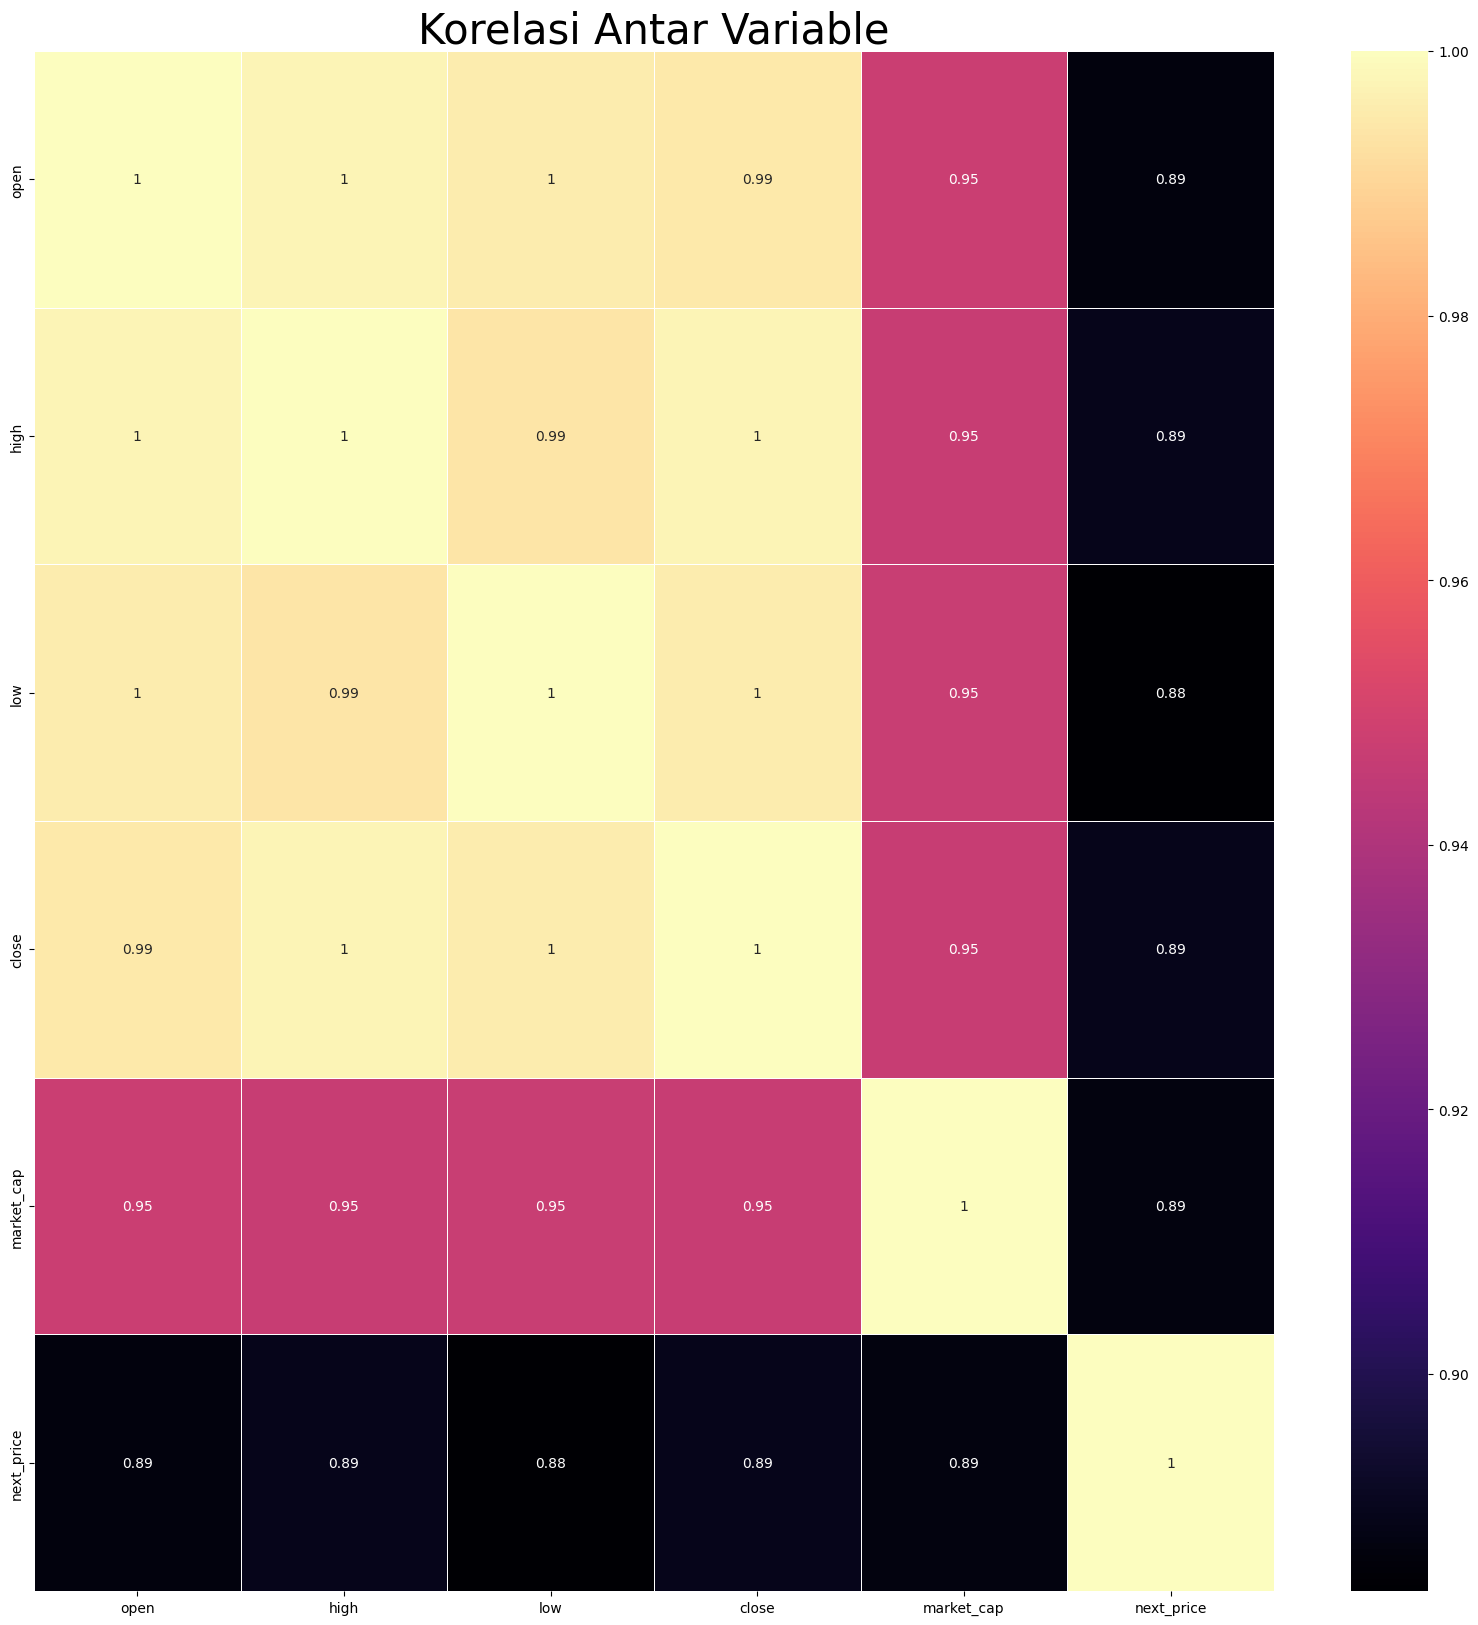

In [25]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

#LSTM

In [40]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-11 20:26:00+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:01+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:02+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:03+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
2025-08-11 20:26:04+00:00,118852.69,118863.61,118831.90,118831.90,2.365074e+12,118823.92
...,...,...,...,...,...,...
2025-08-13 05:15:56+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35
2025-08-13 05:15:57+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35
2025-08-13 05:15:58+00:00,119387.71,119403.23,119387.71,119403.23,2.375739e+12,119128.35


In [ ]:
# =====================================
# 1. Custom Transformer for Scaling 3D Time Series
# =====================================
class TimeSeriesScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        # Reshape from (samples, timesteps, features) → (samples*timesteps, features)
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        self.scaler.fit(X_reshaped)
        return self

    def transform(self, X):
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        X_scaled = self.scaler.transform(X_reshaped)
        return X_scaled.reshape(n_samples, n_timesteps, n_features)

# =====================================
# 2. Function to Build the LSTM Model
# =====================================
SEQ_LEN = 60
def build_lstm_model(units=64, dropout_rate=0.2, optimizer='adam', lr=0.001):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    if optimizer == "adam":
        opt = Adam(learning_rate=lr)
    elif optimizer == "rmsprop":
        opt = RMSprop(learning_rate=lr)
    else:
        raise ValueError("Optimizer not recognized!")

    model.compile(optimizer=opt, loss='mse')
    return model

# =====================================
# 3. Data Preprocessing → Create Time Series Sequences
# =====================================
def create_sequences(X, y, timesteps=60):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i+timesteps)])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

# Feature and target
features = btcdata.drop(columns=['next_price'])
target = btcdata['next_price']

# Create sequences
X_seq, y_seq = create_sequences(features.values, target.values, SEQ_LEN)

# Train-test split (no shuffle to maintain time order)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.25, shuffle=False)

# =====================================
# 4. Optuna Objective Function
# =====================================
def objective(trial):
    # Hyperparameters to tune
    units = trial.suggest_categorical("units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    optimizer = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 20, 50)

    # Pipeline (Scaler + LSTM model)
    pipe = pl([
        ("scaler", TimeSeriesScaler()),
        ("lstm", KerasRegressor(
            model=build_lstm_model,
            units=units,
            dropout_rate=dropout_rate,
            optimizer=optimizer,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        ))
    ])

    # Train and evaluate
    pipe.fit(X_train_seq, y_train_seq, lstm__validation_data=(X_test_seq, y_test_seq))
    val_loss = pipe.named_steps["lstm"].model_.evaluate(X_test_seq, y_test_seq, verbose=0)

    return val_loss

# =====================================
# 5. Run Optuna Tuning (Max 2 Hours)
# =====================================
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=7200)  # 2 hours

print("Best Params:", study.best_params)
print("Best Score:", study.best_value)

# =====================================
# 6. Train the Best Model
# =====================================
best_params = study.best_params

final_pipe = pl([
    ("scaler", TimeSeriesScaler()),
    ("lstm", KerasRegressor(
        model=build_lstm_model,
        units=best_params['units'],
        dropout_rate=best_params['dropout_rate'],
        optimizer=best_params['optimizer'],
        lr=best_params['lr'],
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    ))
])

final_pipe.fit(X_train_seq, y_train_seq, lstm__validation_data=(X_test_seq, y_test_seq))

# =====================================
# 7. Save Model & Parameters
# =====================================
# Save the pipeline (model + scaler)
with open("lstm_crypto_pipeline.pkl", "wb") as f:
    pickle.dump(final_pipe, f)

# Save best hyperparameters
with open("lstm_best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

print("Pipeline and parameters have been successfully saved.")
